# **Classification Based On User Sugar Consumption Pattern**

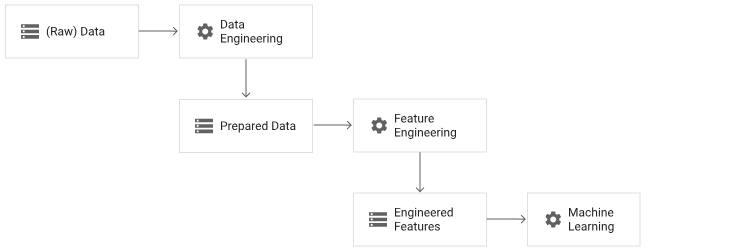

User interactions with our application generate data on food consumption and sugar intake, which provides valuable insights into individual dietary behaviors. This data is collected through user inputs on the amounts of sugar consumed, which undergoes a pre-processing phase. The pre-processing involves cleaning and organizing the raw data to ensure completeness and consistency.

Once processed, the data is used to identify patterns in user behavior, such as irregular reporting or overconsumption of sugar. These insights are then leveraged to generate personalized recommendations, guiding users towards healthier dietary habits. By offering tailored suggestions based on their consumption patterns, the application enhances user engagement and supports long-term health improvements.

In [1]:
# This package is used to install the tensorflow_decision_forests package.
# We chose it rather than YDF (newest version of TFDF) because TFDS helps handle imbalanced data by defining class weights, making it ideal for our classification task.

!pip install tensorflow_decision_forests -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.0 MB/s eta 0:00:00


In [2]:
# Import necessary libraries and dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import ydf
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


In [3]:
# Mount Google Drive to access files stored in Google Drive

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/user_final.csv')

Mounted at /content/drive


<ipython-input-3-f301cfc1d94c>:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/user_final.csv')


In [4]:
# Check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223077 entries, 0 to 2223076
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   User ID    int64 
 1   Date       object
 2   Dish Name  object
 3   Sugar      object
dtypes: int64(1), object(3)
memory usage: 67.8+ MB


In [5]:
# Converting the 'Sugar' column to numeric
df['Sugar'] = pd.to_numeric(df['Sugar'], errors='coerce')


# Converting the 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Aggregating sugar consumption
df_aggregated = df.groupby(['User ID', 'Date']).agg({'Sugar': 'sum'}).reset_index()

# Rename columns
df_aggregated = df_aggregated.rename(columns={'Sugar': 'total_sugar_consumed'})

# Show the result
print(df_aggregated)

        User ID       Date  total_sugar_consumed
0             1 2014-09-15                  63.0
1             1 2014-09-16                 100.0
2             1 2014-09-17                 105.0
3             1 2014-09-18                  71.0
4             1 2014-09-19                  84.0
...         ...        ...                   ...
199995     3363 2015-01-10                   0.0
199996     3363 2015-01-12                   0.0
199997     3363 2015-01-13                   0.0
199998     3363 2015-01-14                   0.0
199999     3363 2015-01-15                   0.0

[200000 rows x 3 columns]


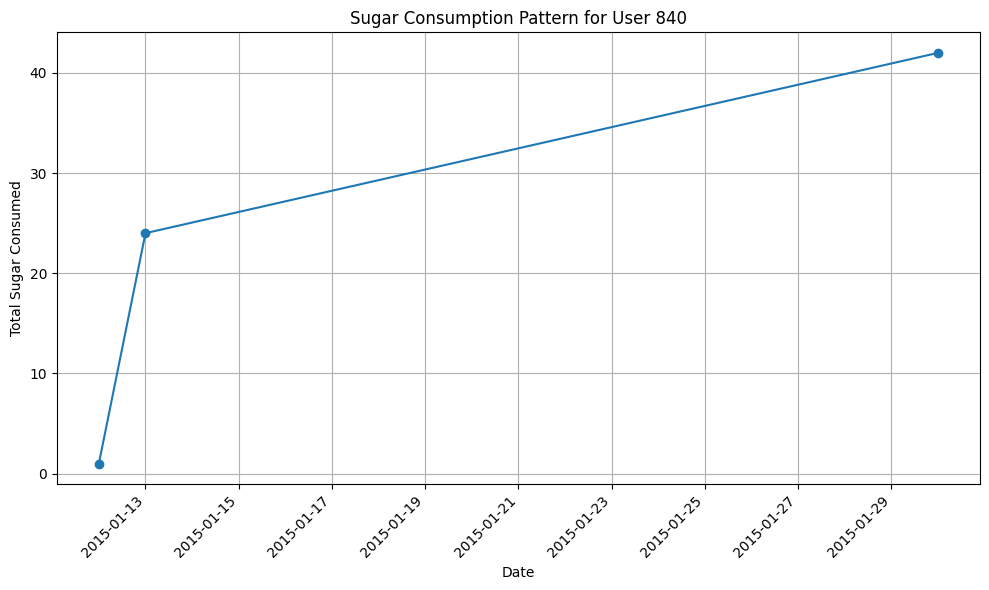

In [6]:
# This one is for checking the user data
user_id_to_plot = 840
user_data = df_aggregated[df_aggregated['User ID'] == user_id_to_plot]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(user_data['Date'], user_data['total_sugar_consumed'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Sugar Consumed')
plt.title(f'Sugar Consumption Pattern for User {user_id_to_plot}')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(True) # Add grid for better visualization
plt.show()

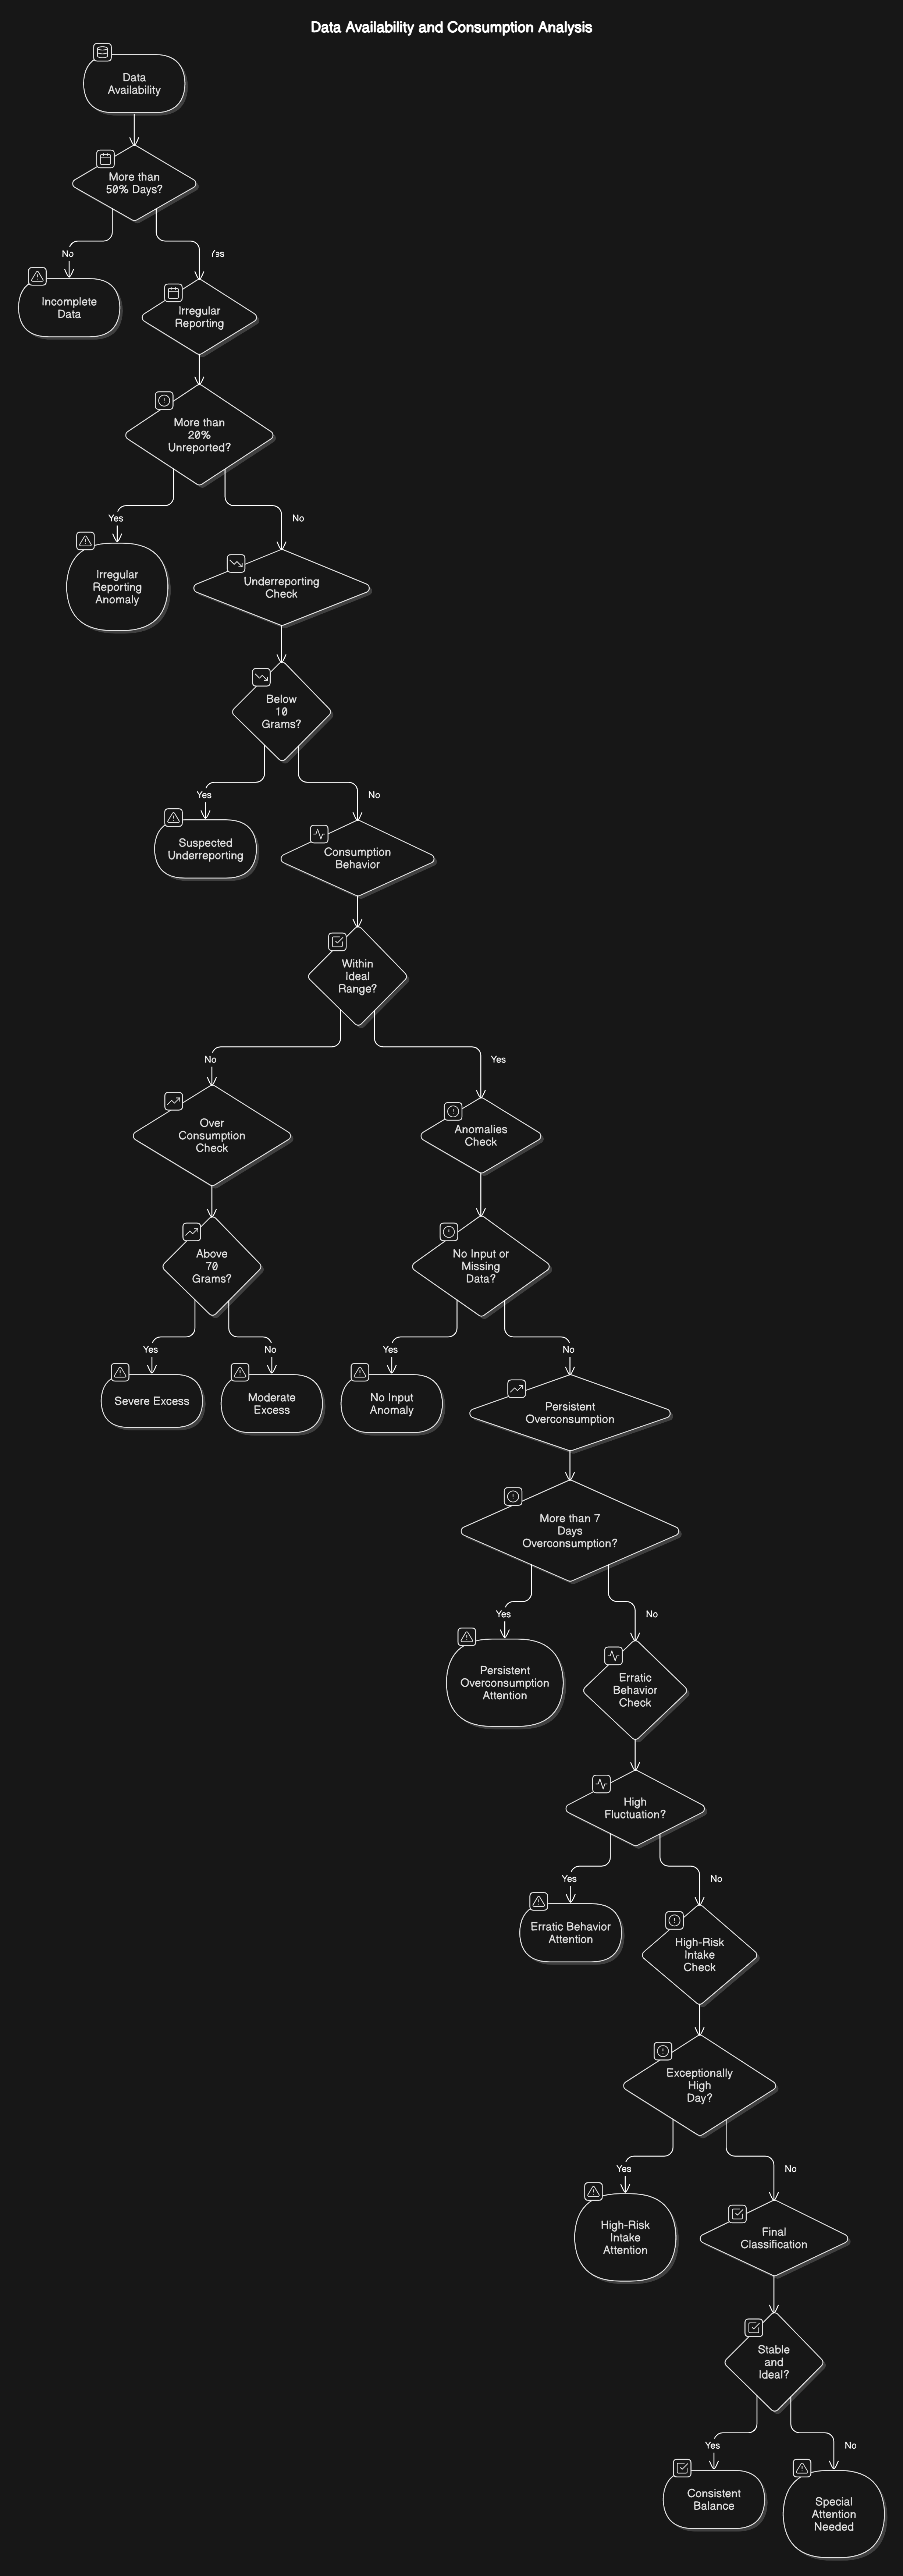

# PREPROCESSING THE DATA


In [7]:
# Calculate important statistics for each user
def aggregate_user_stats(user_data):
    # Date range for missing days calculation
    date_range = pd.date_range(user_data['Date'].min(), user_data['Date'].max(), freq='D')
    total_days = len(date_range)
    reported_days = len(user_data)
    missing_days = total_days - reported_days

    # Sugar consumption statistics
    total_sugar_consumed = user_data['total_sugar_consumed']
    mean_sugar = total_sugar_consumed.mean()
    std_sugar = total_sugar_consumed.std()  # Standard deviation for fluctuation
    max_sugar = total_sugar_consumed.max()

    # Persistent overconsumption (days over 70g)
    persist_overconsumption = (total_sugar_consumed > 70).sum()

    # Excessive sugar days (over 100g)
    excess_days = (total_sugar_consumed > 100).sum()

    # Zero sugar days
    zero_days = (total_sugar_consumed == 0).sum()

    # Return with the calculated values
    return pd.Series({
        'missing_days': missing_days,
        'avg_sugar': mean_sugar,
        'std_sugar': std_sugar,
        'max_sugar': max_sugar,
        'fluctuation': std_sugar,
        'persist_overconsumption': persist_overconsumption,
        'excess_days': excess_days,
        'zero_days': zero_days,
        'total_days': total_days,
        'daily_sugar_consumption': user_data['total_sugar_consumed'].tolist()  # Add daily sugar consumption as a list
    })

# Apply aggregation for all users
classification_df = df_aggregated.groupby('User ID').apply(aggregate_user_stats).reset_index()

print(classification_df)


      User ID  missing_days   avg_sugar  std_sugar  max_sugar  fluctuation  \
0           1             6   81.606936  38.629672      183.0    38.629672   
1           2             0   76.216667  25.125510      154.0    25.125510   
2           3             3    0.000000   0.000000        0.0     0.000000   
3           4           106    0.000000   0.000000        0.0     0.000000   
4           5             0  121.268156  46.248057      254.0    46.248057   
...       ...           ...         ...        ...        ...          ...   
3358     3359            35   47.354167  14.663817       84.0    14.663817   
3359     3360           122   94.800000  46.714816      181.0    46.714816   
3360     3361            56    0.000000   0.000000        0.0     0.000000   
3361     3362             0   87.192661  32.058245      159.0    32.058245   
3362     3363            29    0.000000   0.000000        0.0     0.000000   

      persist_overconsumption  excess_days  zero_days  total_da

<ipython-input-7-383322d06092>:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  classification_df = df_aggregated.groupby('User ID').apply(aggregate_user_stats).reset_index()


In [8]:
def label_user_behavior(row):

    # Check if the proportion of missing days is more than 50%
    if row['missing_days'] / row['total_days'] > 0.5:
        return 'incomplete data'

    # Check for zero consumption days
    if row['zero_days'] / row['total_days'] > 0.2:
        return 'irregular reporting'

    # Check for suspected underreporting
    if row['avg_sugar'] < 10 :
        return 'suspected underreporting'

    # Classify sugar consumption based on average sugar
    if row['avg_sugar'] <= 50:
        pass
    else:
        return 'severe addiction' if row['avg_sugar'] >= 70 else 'moderate addiction'

    # Handling cases where the user has no input data
    if row['missing_days'] == row['total_days']:
        return 'no input'

    # Classify based on persistent overconsumption
    if row['persist_overconsumption'] > 7:
        return 'persistent overconsumption'

    # Classify based on fluctuation in sugar consumption
    if row['fluctuation'] > 20:
        return 'erratic behavior'

    # Classify based on high-risk sugar intake (more than 100g)
    if any(consumption > 100 for consumption in row['daily_sugar_consumption']):
        return 'high-risk intake'

    # Default to consistent balance if none of the above conditions are met
    return 'consistent balance'

classification_df['user_behavior'] = classification_df.apply(label_user_behavior, axis=1)

In [9]:
# Counting the amount of unique user_behavior
behavior_counts = classification_df['user_behavior'].value_counts()

# Print the total number of users based on user behaviour classification
total_users = classification_df['User ID'].nunique()
print(f'Total number of users: {total_users}')

print(behavior_counts)


Total number of users: 3363
user_behavior
incomplete data               1610
irregular reporting            611
moderate addiction             294
persistent overconsumption     216
consistent balance             215
severe addiction               191
erratic behavior               165
suspected underreporting        38
high-risk intake                23
Name: count, dtype: int64


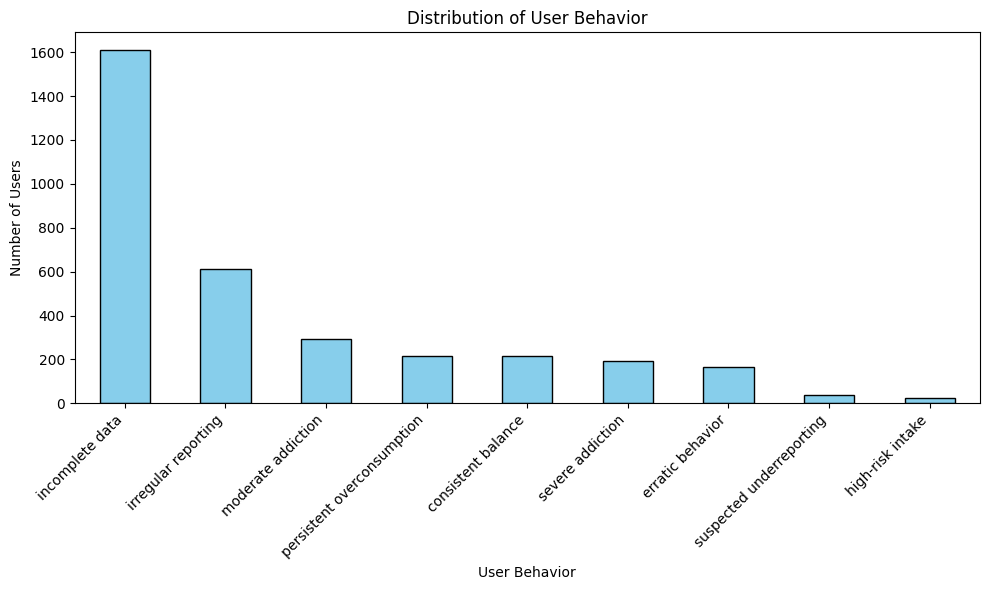

In [10]:
# Plotting the distribution
plt.figure(figsize=(10, 6))
behavior_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of User Behavior')
plt.xlabel('User Behavior')
plt.ylabel('Number of Users')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better visibility
plt.tight_layout()
plt.show()


In [11]:
# Convert data in user_behavior to numeric labels

label_encoder = LabelEncoder()
classification_df['user_behavior_encoded'] = label_encoder.fit_transform(classification_df['user_behavior'])
print(classification_df[['user_behavior', 'user_behavior_encoded']].drop_duplicates())


                 user_behavior  user_behavior_encoded
0             severe addiction                      7
2          irregular reporting                      4
3              incomplete data                      3
8           moderate addiction                      5
11          consistent balance                      0
12            high-risk intake                      2
21    suspected underreporting                      8
39            erratic behavior                      1
40  persistent overconsumption                      6


 **Insight from the data**

The classification of user behavior in tracking sugar consumption shows varying levels of engagement and data accuracy. Many users exhibit inconsistent or incomplete reporting, highlighting the need for better engagement strategies. For those with moderate to severe sugar overconsumption, personalized interventions and professional support are essential. A smaller group maintains a balanced sugar intake, which could serve as role models. Users with erratic behavior or suspected underreporting may require further investigation into their eating habits and motivations. Overall, the insights gained from preprocessing the data emphasize the importance of tailored interventions to promote healthier and more consistent sugar consumption.

In [12]:
# Defining features
features = ['avg_sugar', 'std_sugar', 'max_sugar', 'excess_days', 'missing_days', 'zero_days', 'fluctuation', 'persist_overconsumption']
X = classification_df[features].values
y = classification_df['user_behavior_encoded'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)


In [15]:
# Preparing the data (
train_data = pd.DataFrame(X_train, columns=features)
train_data['label'] = y_train
test_data = pd.DataFrame(X_test, columns=features)
test_data['label'] = y_test

# Train the Random Forest model using ydf
random_forest_model = ydf.RandomForestLearner(label="label", num_trees=100).train(train_data)

# Evaluate the model on the test dataset
evaluation_results = random_forest_model.evaluate(test_data)

# Display the evaluation results
print("Evaluation Results:")
print(evaluation_results)


Train model on 2522 examples
Model trained in 0:00:00.323133
Evaluation Results:
accuracy: 0.950059
confusion matrix:
    label (row) \ prediction (col)
    +-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
    |     |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |
    +-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
    |   0 |  45 |   0 |   0 |   5 |   0 |   0 |   0 |   0 |   0 |
    +-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
    |   1 |   0 |  36 |   0 |   7 |   0 |   0 |   0 |   0 |   0 |
    +-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
    |   2 |   0 |   1 |   3 |   0 |   0 |   0 |   0 |   0 |   0 |
    +-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
    |   3 |   2 |   5 |   0 | 369 |   1 |   2 |   6 |   7 |   1 |
    +-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
    |   4 |   0 |   1 |   0 |   1 | 146 |   0 |   0 |   0 |   0 |
    +-----+-----+-----+-----+-----+-----+-----+-----+--

In [16]:
# Example of predicting the classification
predictions = random_forest_model.predict(test_data) # Using 'test_data' instead of the undefined 'processed_test_dataset'

# Access the predictions directly as a NumPy array
predicted_behavior = predictions

Notification options are defined based on various user behavior patterns regarding sugar consumption. The following categories are considered for generating user notifications:

- Incomplete Data User: For users who have missing or incomplete data.
- Irregular Reporting Anomaly: For users who are inconsistent in reporting their sugar consumption.
- Suspected Underreporting: For users who report very low sugar consumption, potentially due to underreporting.
- Severe Addiction: For users who consume excessive amounts of sugar daily.
- Moderate Addiction: For users who consume moderately excessive amounts of sugar daily.
- No Input Anomaly: For users who haven't entered data for a long time.
- Persistent Overconsumption Attention: For users who consistently overconsume sugar.
- Erratic Behavior Attention: For users who show erratic sugar consumption patterns.
- High Risk Intake Attention: For users who have very high sugar intake on certain days.
- Consistent Balance: For users who have a balanced and healthy sugar consumption pattern.
- Special Attention Needed: For users who need special attention based on their sugar consumption behavior.

These notifications aim to guide users in tracking their sugar consumption and maintaining healthy eating habits.

In [17]:
message_options = {
    'Incomplete Data User': [
        "Kayaknya data konsumsi gula kamu kurang nih, coba deh catat konsumsi gula kamu minimal 50% supaya kita bisa kasih rekomendasi yang lebih akurat. Kalau kamu merasa ketagihan gula, yuk, coba mulai track biar bisa atur pola makan lebih baik!",
        "Data yang kamu input kayaknya belum lengkap. Biar bisa bantu kamu perbaiki pola makan, pastiin kamu catat konsumsi gula secara rutin, ya! Dengan data yang lebih lengkap, kita bisa kasih solusi yang cocok untuk kamu.",
        "Ada beberapa hari yang datanya hilang nih. Jangan sampai ketagihan gula bikin kamu lupa track. Pastikan untuk catat konsumsi gula kamu secara konsisten supaya kita bisa kasih feedback yang lebih pas buat kamu.",
        "Ingat, konsistensi penting banget! Ketagihan gula bisa bikin pola makan kamu nggak terkontrol, jadi pastikan data konsumsi gula kamu lengkap supaya kita bisa bantu atasi masalah ini.",
        "Biar kita bisa bantu kamu lebih maksimal, pastikan konsumsi gula tercatat dengan lengkap. Dengan begitu, kita bisa tahu kalau ada ketagihan gula yang harus kamu perhatikan dan bantu cari solusi yang tepat."
    ],
    'Irregular Reporting Anomaly': [
        "Kita lihat ada lebih dari 20% hari yang belum tercatat, jadi agak susah buat ngasih rekomendasi yang bermanfaat. Kalau kebiasaan makan kamu sering ketagihan gula, coba lebih rajin catat konsumsi gula kamu, ya!",
        "Data konsumsi gula kamu keliatan ada banyak celah. Kalau kamu lagi ketagihan gula, coba kontrol dan laporin secara rutin supaya kita bisa kasih insight lebih baik buat kamu.",
        "Kayaknya kamu sering kelewatan catat konsumsi gula. Kalau kamu merasa ketagihan gula, coba deh input datanya lebih konsisten supaya kita bisa kasih saran yang pas buat bantu atasi ketergantungan kamu.",
        "Kebiasaan ketagihan gula bisa bikin pelaporan jadi nggak teratur. Coba lebih rajin catat konsumsi gula kamu supaya kita bisa bantu mengatur asupan gula kamu dengan lebih baik.",
        "Coba buat kebiasaan track konsumsi gula yang lebih teratur. Dengan catatan yang lebih konsisten, kita bisa bantu kamu mengatasi ketagihan gula yang bisa mempengaruhi pola makan."
    ],
    'Suspected Underreporting': [
        "Konsumsi gula kamu kok selalu di bawah 10 gram ya? Bisa jadi ini gara-gara kamu yang gak rajin lapor ke kita, lho. Kalau emang bener gitu, kasih konfirmasi, ya! Kalau nggak, pastiin catat semua konsumsi gula kamu biar bisa kasih feedback yang akurat dan bantu atasi ketagihan gula.",
        "Kamu kelihatan sering lapor konsumsi gula di bawah 10 gram. Cek lagi deh datanya atau kasih tau kami kalau ada alasan medis buat asupan gula yang rendah ini, atau mungkin ketagihan gula kamu masih bisa terkontrol.",
        "Kayaknya konsumsi gula kamu konsisten rendah. Kalau kamu yakin gitu, kasih konfirmasi, atau pastiin semua data kamu udah bener supaya bisa dapet rekomendasi yang tepat, apalagi buat kamu yang mau bebas dari ketagihan gula.",
        "Jika kamu merasa konsumsi gula kamu memang rendah, coba pastikan datanya akurat. Ketagihan gula bisa menyebabkan underreporting yang mengganggu, jadi pastikan semuanya tercatat dengan jelas.",
        "Sering mencatat konsumsi gula yang rendah bisa jadi tanda kamu menghindari atau kurang memperhatikan asupan gula yang sebenarnya. Kita perlu data yang akurat untuk bantu atasi ketagihan gula yang mungkin terjadi."
    ],
    'Severe Addiction': [
        "Asupan gula kamu konsisten di atas 70 gram per hari, itu udah kelebihan banget! Bisa bahaya buat kesehatan dan bikin ketagihan gula makin parah. Mending kurangi asupan gula kamu dan konsultasi ke profesional, ya.",
        "Kamu rutin konsumsi lebih dari 70 gram gula per hari, itu bisa menyebabkan masalah kesehatan jangka panjang kayak diabetes, plus bikin ketagihan gula makin susah dihindari. Kurangi deh asupan gula dan coba konsultasi sama dokter.",
        "Konsumsi gula di atas 70 gram sehari udah kelebihan parah! Itu bisa pengaruh ke kesehatan kamu dan membuat ketagihan gula lebih sulit dihentikan. Sebaiknya kurangi konsumsi gula dan bicarakan sama profesional kesehatan.",
        "Kelebihan konsumsi gula yang terus-terusan bisa jadi tanda ketagihan gula. Kamu perlu banget kontrol asupan gula buat jaga kesehatan dan hindari masalah yang lebih serius.",
        "Sering konsumsi lebih dari 70 gram gula bisa memperparah ketagihan gula. Sebaiknya mulai kurangi konsumsi gula dan konsultasi ke ahli gizi untuk bantu atasi pola makan yang tidak sehat."
    ],
    'Moderate Addiction': [
        "Konsumsi gula kamu antara 50 hingga 70 gram per hari, itu udah tergolong kelebihan gula. Walaupun nggak seberat yang parah, mending kurangi supaya tetap dalam batas yang sehat dan nggak makin ketagihan gula.",
        "Kamu konsumsi antara 50-70 gram gula per hari, itu udah termasuk kelebihan gula. Tetap hati-hati, jangan sampe ketagihan gula terus, ya!",
        "Kelebihan gula dalam rentang 50 sampai dengan 70 gram bisa tetep berisiko untuk kesehatan. Mending coba kurangi konsumsi gula dan ganti makanan manis dengan yang lebih sehat supaya bisa terhindar dari ketagihan gula.",
        "Walaupun nggak setinggi yang parah, konsumsi gula yang berlebihan ini bisa mengarah pada ketagihan gula. Kurangi sedikit demi sedikit buat pola makan yang lebih sehat dan bebas dari ketergantungan.",
        "Terlalu sering konsumsi gula lebih dari 50 gram bisa bikin ketagihan gula makin sulit dikendalikan. Yuk, mulai kurangi sedikit demi sedikit supaya bisa atasi kebiasaan ini."
    ],
    'No Input Anomaly': [
        "Kok udah lama banget nggak input konsumsi gula ya? Coba deh track lagi secara rutin supaya kita bisa kasih insight yang lebih oke buat kebiasaan kamu, biar ketagihan gula kamu bisa dikendalikan.",
        "Sepertinya ada beberapa hari yang nggak ada data konsumsi gula. Coba untuk selalu input data konsumsi gula supaya kamu dapet rekomendasi yang tepat dan bisa track kemajuan kamu dalam mengatasi ketagihan gula.",
        "Udah beberapa hari nih nggak ada data konsumsi gula. Penting banget buat input konsumsi gula kamu setiap hari supaya kita bisa track kebiasaan kamu dan kasih feedback yang berguna untuk mengurangi ketagihan gula.",
        "Lama nggak input konsumsi gula bisa bikin pola makan kamu nggak terkontrol, apalagi kalau ketagihan gula. Yuk, mulai rajin input data konsumsi gula supaya kita bisa bantu lebih cepat.",
        "Jangan biarkan ketagihan gula menguasai kamu. Mulai input data konsumsi gula lagi secara rutin supaya kita bisa bantu kamu mengelola pola makan lebih baik."
    ],
    'Persistent Overconsumption Attention': [
        "Konsumsi gula kamu udah terus-terusan lebih dari 70 gram per hari selama lebih dari 7 hari, itu bahaya banget buat kesehatan dan bisa bikin ketagihan gula semakin parah. Coba kurangi deh asupan gula kamu.",
        "Selama lebih dari 7 hari, konsumsi gula kamu selalu tinggi (di atas 70 gram per hari). Ini bisa jadi masalah kesehatan dan memperparah ketagihan gula kamu. Mending mulai kurangi konsumsi gula kamu, ya.",
        "Konsumsi gula kamu tinggi banget (di atas 70 gram per hari) selama beberapa hari. Kita sarankan banget buat kurangi konsumsi gula dan konsultasi sama profesional kesehatan supaya ketagihan gula bisa diatasi.",
        "Jika konsumsi gula tinggi ini terus-terusan, bisa memperparah ketagihan gula yang kamu alami. Mending mulai kurangi sedikit demi sedikit supaya nggak lebih buruk lagi.",
        "Ketagihan gula yang berlanjut bisa punya dampak besar. Coba kurangi konsumsi gula kamu secara bertahap dan pertimbangkan untuk cari bantuan medis."
    ],
    'Erratic Behavior Attention': [
        "Konsumsi gula kamu keliatan nggak stabil, ada fluktuasi tinggi, celah data, dan kadang-kadang kelebihan. Ini bisa tanda pola makan yang nggak stabil, mungkin juga karena ketagihan gula. Coba buat track yang lebih konsisten dan jaga pola makan yang lebih stabil.",
        "Kami lihat ada fluktuasi dan celah di konsumsi gula kamu. Ini bisa berdampak ke kesehatan, lho, dan memperburuk ketagihan gula. Coba buat jadwal yang lebih konsisten dan kurangi variasi asupan gula kamu.",
        "Pola konsumsi gula kamu keliatan nggak konsisten banget. Mungkin perlu bikin diet yang lebih stabil dan rutin supaya hasil kesehatan yang lebih baik, dan supaya ketagihan gula bisa hilang.",
        "Pola konsumsi gula yang nggak stabil ini bisa jadi akibat ketagihan gula. Mulai coba atur jadwal makan yang lebih teratur dan hindari fluktuasi yang nggak sehat.",
        "Ketagihan gula sering menyebabkan pola makan yang nggak stabil. Coba konsisten dengan asupan gula kamu dan hindari lonjakan tinggi supaya bisa bantu atasi kebiasaan ini."
    ],
    'High Risk Intake Attention': [
        "Di beberapa hari, konsumsi gula kamu udah mencapai level bahaya. Itu bisa jadi masalah kesehatan serius dan meningkatkan ketagihan gula. Coba deh kurangi hari-hari dengan asupan gula tinggi dan konsultasi sama dokter.",
        "Konsumsi gula kamu udah tinggi banget di beberapa hari, bisa berisiko buat kesehatan dan jadi makin susah lepas dari ketagihan gula. Coba kurangi asupan gula tinggi ini dan pertimbangkan untuk cari nasihat medis.",
        "Kamu punya hari-hari dengan konsumsi gula yang sangat tinggi, ini bisa jadi risiko kesehatan dan memperburuk ketagihan gula. Penting banget buat monitor asupan kamu dan hindari hari-hari berisiko tinggi itu ke depan.",
        "Hari-hari dengan asupan gula tinggi bisa memperburuk ketagihan gula. Coba mulai perhatikan hari-hari itu dan kurangi konsumsi gula secara signifikan.",
        "Hindari konsumsi gula yang sangat tinggi. Ini bisa memicu ketagihan gula dan masalah kesehatan lainnya. Cobalah untuk menurunkan asupan gula dan kontrol pola makan kamu."
    ],
    'Consistent Balance': [
        "Mantap! Konsumsi gula kamu seimbang, dengan sedikit kebablasan yang nggak masalah. Terus jaga pola makan sehat ini dan terus track asupan kamu buat hasil terbaik, biar ketagihan gula nggak kambuh.",
        "Konsumsi gula kamu ada di angka yang sehat, meski kadang sedikit kelebihan. Terus pertahankan pola makan sehat kamu dan jaga konsistensinya supaya ketagihan gula nggak muncul lagi.",
        "Kerja bagus! Asupan gula kamu masih di angka ideal, cuma sedikit kebablasan sesekali. Tetap jaga keseimbangan ini buat gaya hidup sehat dan hindari ketagihan gula.",
        "Kamu udah sukses menjaga konsumsi gula dalam batas sehat! Terus pertahankan pola makan ini supaya ketagihan gula tetap terkontrol.",
        "Konsistensi ini penting untuk menjaga pola makan yang sehat. Terus seimbang, dan pastikan ketagihan gula kamu tetap terkendali."
    ],
    'Special Attention Needed': [
        "Berdasarkan pola konsumsi gula kamu, kami sarankan perhatian khusus. Penting banget buat jaga kadar gula kamu supaya gak makin ketagihan.",
        "Pola konsumsi kamu butuh perhatian khusus. Kami sarankan untuk lebih waspada dalam mengelola asupan gula supaya nggak ketagihan.",
        "Pola konsumsi gula kamu menunjukkan perlu perhatian lebih. Jaga pola konsumsi gula kamu dengan hati-hati, baik itu karena kelebihan, fluktuasi, atau asupan yang berisiko, supaya ketagihan gula bisa teratasi.",
        "Perhatian ekstra diperlukan buat kamu yang struggle dengan ketagihan gula. Pastikan konsumsi gula tetap terkontrol untuk menjaga kesehatan dan menghindari risiko kesehatan jangka panjang.",
        "Kami lihat ada pola konsumsi gula yang perlu perhatian ekstra. Pastikan untuk lebih fokus supaya ketagihan gula nggak jadi masalah buat kamu."
    ]
}


In [22]:

def get_shuffled_message_based_on_classification(predicted_class):
    # Get the list of options for the predicted category
    options = message_options.get(predicted_class)

    # Shuffle the options list to randomize the order
    random.shuffle(options)

    # Return the first option from the shuffled list
    return options[0]

# Example usage for a user with predicted behavior category 'Irregular Reporting Anomaly'
predicted_message = 'Irregular Reporting Anomaly'  # This would come from your model's prediction
message_notification = get_shuffled_message_based_on_classification(predicted_message)
print(message_notification)

Kayaknya kamu sering kelewatan catat konsumsi gula. Kalau kamu merasa ketagihan gula, coba deh input datanya lebih konsisten supaya kita bisa kasih saran yang pas buat bantu atasi ketergantungan kamu.


In [23]:
notification_options = {
    'Incomplete Data User': [
        "Mulai catat konsumsi gula secara konsisten.",
        "Pastikan data kamu terisi lengkap tiap hari.",
        "Catat konsumsi gula setiap kali makan.",
        "Jangan lupa input konsumsi gula tiap hari.",
        "Cobalah laporkan semua konsumsi gula yang dimakan.",
        "Perhatikan setiap camilan yang kamu konsumsi.",
        "Dengan data lengkap, kita bisa bantu lebih maksimal."
    ],
    'Irregular Reporting Anomaly': [
        "Catat konsumsi gula setiap waktu makan.",
        "Jangan lewatkan laporan konsumsi gula tiap hari.",
        "Jaga konsistensi dengan mencatat gula secara teratur.",
        "Pastikan untuk memasukkan data gula tiap waktu makan.",
        "Laporan gula harus dilakukan dengan konsisten.",
        "Cobalah untuk selalu melaporkan konsumsi gula.",
        "Dengan data yang stabil, kami bisa bantu lebih baik."
    ],
    'Suspected Underreporting': [
        "Catat setiap konsumsi gula dengan detail.",
        "Perhatikan asupan gula yang kamu makan.",
        "Jangan abaikan konsumsi gula yang rendah.",
        "Pastikan semua konsumsi gula tercatat dengan baik.",
        "Lapor konsumsi gula setiap kali makan.",
        "Jika kamu merasa gula rendah, pastikan laporan sesuai.",
        "Dengan data yang lebih akurat, kita bisa bantu lebih efektif."
    ],
    'Severe Addiction': [
        "Kurangi konsumsi gula sedikit demi sedikit.",
        "Pilih makanan rendah gula untuk jaga pola makan.",
        "Hindari makanan manis yang berlebihan.",
        "Gantilah camilan manis dengan buah atau kacang.",
        "Tetap kendalikan asupan gula di setiap waktu makan.",
        "Pilih minuman tanpa gula untuk menggantikan soda.",
        "Konsultasi dengan ahli jika perlu untuk kontrol lebih lanjut."
    ],
    'Moderate Addiction': [
        "Kurangi konsumsi gula secara bertahap.",
        "Mulailah dengan pengurangan 10-20% konsumsi gula.",
        "Pilih makanan dengan kadar gula rendah.",
        "Cobalah camilan sehat seperti buah segar.",
        "Batasi konsumsi gula dalam setiap makanan.",
        "Atur pola makan dengan porsi yang tepat.",
        "Lakukan pemantauan gula secara rutin untuk hasil terbaik."
    ],
    'No Input Anomaly': [
        "Mulai catat konsumsi gula tiap kali makan.",
        "Jangan biarkan hari tanpa laporan konsumsi gula.",
        "Catat konsumsi gula di setiap makanan dan minuman.",
        "Pastikan tidak ada hari yang terlewat untuk mencatat.",
        "Setiap hari, pastikan data gula kamu lengkap.",
        "Gunakan aplikasi untuk bantu melacak konsumsi gula.",
        "Jangan lupa untuk melakukan update data tiap hari."
    ],
    'Persistent Overconsumption Attention': [
        "Kurangi konsumsi gula lebih dari 20%.",
        "Jangan makan makanan manis terlalu sering.",
        "Pilih makanan sehat yang tidak mengandung banyak gula.",
        "Batasi konsumsi gula di hari-hari berikutnya.",
        "Hindari konsumsi gula lebih dari 70 gram sehari.",
        "Gantilah minuman manis dengan air putih.",
        "Cobalah untuk menurunkan konsumsi gula secara bertahap."
    ],
    'Erratic Behavior Attention': [
        "Stabilkan konsumsi gula dengan pola yang teratur.",
        "Hindari fluktuasi konsumsi gula tiap hari.",
        "Pastikan tidak ada lonjakan gula yang besar.",
        "Kurangi pola makan yang tidak stabil.",
        "Cobalah untuk menjaga pola makan yang teratur.",
        "Buat jadwal makan dengan porsi gula yang tepat.",
        "Pastikan konsumsi gula tetap konsisten setiap hari."
    ],
    'High Risk Intake Attention': [
        "Kurangi konsumsi gula lebih dari 20%.",
        "Batasi gula yang sangat tinggi setiap hari.",
        "Gantilah camilan manis dengan buah segar.",
        "Jaga asupan gula agar tetap dalam batas wajar.",
        "Hindari hari-hari dengan konsumsi gula berlebihan.",
        "Pilih makanan dengan gula rendah untuk makan siang.",
        "Konsultasi dengan ahli jika asupan gula tinggi berlanjut."
    ],
    'Consistent Balance': [
        "Pertahankan konsumsi gula yang seimbang setiap hari.",
        "Pastikan konsumsi gula tetap stabil tiap waktu makan.",
        "Jangan terlalu banyak mengonsumsi gula di satu waktu.",
        "Cobalah memilih camilan sehat tanpa gula berlebih.",
        "Jaga keseimbangan dengan mengatur pola makan.",
        "Pilih makanan sehat yang mendukung keseimbangan gula.",
        "Terus monitor konsumsi gula agar tetap stabil."
    ],
    'Special Attention Needed': [
        "Perhatikan konsumsi gula dengan lebih hati-hati.",
        "Kurangi gula lebih ketat setiap harinya.",
        "Cobalah makan dengan porsi gula yang lebih kecil.",
        "Kendalikan konsumsi gula agar tetap dalam batas wajar.",
        "Fokus pada pola makan yang rendah gula.",
        "Batasi makanan manis untuk kontrol lebih lanjut.",
        "Jaga konsumsi gula tetap terkontrol dengan disiplin."
    ]
}


In [24]:

def get_shuffled_notification_based_on_classification(predicted_class):
    # Get the list of options for the predicted category
    options = notification_options.get(predicted_class)

    # Shuffle the options list to randomize the order
    random.shuffle(options)

    # Return the first option from the shuffled list
    return options[0]

# Example usage for a user with predicted behavior category 'Irregular Reporting Anomaly'
predicted_class = 'Irregular Reporting Anomaly'  # This would come from your model's prediction
selected_notification = get_shuffled_notification_based_on_classification(predicted_class)

In [25]:
print(selected_notification)

Catat konsumsi gula setiap waktu makan.


DEPLOY THE MODEL

In [26]:
random_forest_model.save("/tmp/ranfor_model")

# Zip the model directory for easy distribution
!zip -rj /tmp/ranfor_model.zip /tmp/ranfor_model

  adding: random_forest_header.pb (deflated 89%)
  adding: nodes-00000-of-00001 (deflated 85%)
  adding: data_spec.pb (deflated 22%)
  adding: header.pb (deflated 28%)
  adding: done (stored 0%)


In [27]:
from google.colab import files
files.download('/tmp/ranfor_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>